<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_Identificaci%C3%B3n_de_escenarios_naturales_del_mundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Identificación de escenarios naturales del mundo

**Nombre**: Pablo Saavedra <br />
**Curso**: Modelos avanzados y Redes Neuronales (G105)


---

### Importación de librerías

In [1]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, Rescaling, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, Dropout, Flatten, Dense
)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format



In [2]:
import tensorflow as tf

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
!nvidia-smi


Mon Feb 16 01:52:06 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Funciones útiles

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto', _title=""):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col} {_title}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


def eval_model_short(name, model):
  y_pred = model.predict(X_test)
  # Para AUC necesitamos probas de clase 1
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

  print(f"{name:>18} | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")


def plot_corr(
    df,
    method="pearson",
    figsize=(12, 10),
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
):
    """
    Muestra un heatmap de la matriz de correlación de un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada
    method : str
        Método de correlación: 'pearson', 'spearman', 'kendall'
    figsize : tuple
        Tamaño de la figura
    annot : bool
        Mostrar valores numéricos en el heatmap
    cmap : str
        Colormap
    vmin, vmax : float
        Límites de la escala de correlación
    """

    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include="number")

    if df_num.shape[1] < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Calcular correlación
    corr = df_num.corr(method=method)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Matriz de correlación ({method})", fontsize=14)
    plt.tight_layout()
    plt.show()

def show_images(images, target, pred=[], nrow=2, ncol=4):

    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(4 + ncol, 4 + nrow/2.5),
                          sharex=True, sharey=True)

    for i in range(nrow):
        for j in range(ncol):
            alea = np.random.randint(0, images.shape[0]+1)
            ax[i, j].imshow(images[alea])
            tit = '['+target[alea] + ']'
            if len(pred) > 0:
             tit += ' ' + pred[alea]
            ax[i, j].set_title(tit, fontsize=10)
            ax[i, j].set_axis_off()
    plt.tight_layout()
    plt.show();

In [4]:
from typing import Optional, Iterable, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

def eval_model_preds(
    X_train, y_train,
    X_test,  y_test,
    y_pred_train,
    y_pred_test,
    class_names: Optional[Iterable[str]] = None,
    *,
    normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
    average: str = "weighted",           # "macro" | "weighted" | "micro"
    plot: bool = True,
    title_prefix: str = "",
    # scores para binario (p.ej. proba[:,1] o decision_function)
    pos_scores_train: Optional[np.ndarray] = None,
    pos_scores_test: Optional[np.ndarray] = None,
    binary_threshold: Optional[float] = None,  # si no None y hay scores, recalcula y_pred
    zero_division: int = 0,
    label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
    """
    Evalúa un clasificador en train/test con métricas y (opcional) gráficos,
    recibiendo predicciones ya calculadas (sin pasar el modelo).

    - y_pred_train/y_pred_test: predicción final (clase).
    - pos_scores_* (opcional): scores de clase positiva para AUC/ROC/PR (binario).
    """

    # ---------------------------
    # 0) Preparación / tipos
    # ---------------------------
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)
    y_pred_train = np.asarray(y_pred_train)
    y_pred_test  = np.asarray(y_pred_test)

    target_kind = type_of_target(y_test)
    is_binary = target_kind == "binary"

    # Si viene un mapeo explícito, aplícalo a y_* reales
    if label_map is not None:
        y_train = np.vectorize(label_map.get)(y_train)
        y_test  = np.vectorize(label_map.get)(y_test)

    # Si hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
    def _needs_alignment(y_true, y_pred):
        return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

    if _needs_alignment(y_test, y_pred_test):
        if not is_binary:
            raise TypeError(
                "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
                "Pasa 'label_map' o codifica etiquetas (LabelEncoder)."
            )
        if class_names is not None and len(list(class_names)) == 2:
            auto_map = {list(class_names)[0]: 0, list(class_names)[1]: 1}
            y_train = np.vectorize(auto_map.get)(y_train)
            y_test  = np.vectorize(auto_map.get)(y_test)
        else:
            uniq = list(np.unique(y_train))
            if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
                auto_map = {uniq[0]: 0, uniq[1]: 1}
                y_train = np.vectorize(auto_map.get)(y_train)
                y_test  = np.vectorize(auto_map.get)(y_test)
            else:
                raise TypeError(
                    "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                    "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
                )

    # ---------------------------
    # 1) Umbral binario (si aplica) usando scores
    # ---------------------------
    if is_binary and (pos_scores_train is not None or pos_scores_test is not None) and (binary_threshold is not None):
        thr = float(binary_threshold)
        if pos_scores_train is not None:
            y_pred_train = (np.asarray(pos_scores_train) >= thr).astype(int)
        if pos_scores_test is not None:
            y_pred_test  = (np.asarray(pos_scores_test)  >= thr).astype(int)

    # ---------------------------
    # 2) Métricas numéricas
    # ---------------------------
    metrics: Dict[str, Any] = {}

    def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=average, zero_division=zero_division
        )
        mcc = matthews_corrcoef(y_true, y_pred)
        return {
            f"{split}_accuracy": acc,
            f"{split}_balanced_accuracy": bacc,
            f"{split}_precision_{average}": p,
            f"{split}_recall_{average}": r,
            f"{split}_f1_{average}": f1,
            f"{split}_mcc": mcc
        }

    metrics.update(block_metrics(y_train, y_pred_train, "train"))
    metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

    # AUCs si tenemos scores (binario)
    if is_binary and (pos_scores_test is not None):
        try:
            if pos_scores_train is not None:
                metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
                metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
            metrics["test_roc_auc"] = roc_auc_score(y_test, pos_scores_test)
            metrics["test_pr_auc"]  = average_precision_score(y_test, pos_scores_test)
        except Exception:
            pass

    # ---------------------------
    # 3) Reportes por clase
    # ---------------------------
    prefix = (title_prefix + " ") if title_prefix else ""
    print(prefix + "Reporte de clasificación (train):")
    print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
    print(prefix + "Reporte de clasificación (test):")
    print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

    # ---------------------------
    # 4) Gráficos
    # ---------------------------
    if plot:
        has_scores = is_binary and (pos_scores_test is not None)
        fig, axes = (plt.subplots(2, 2, figsize=(10, 8)) if has_scores
                     else plt.subplots(1, 2, figsize=(10, 4)))
        axes = np.array(axes).flatten()

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_train, y_pred=y_pred_train,
            display_labels=class_names, normalize=normalize_cm, ax=axes[0]
        )
        axes[0].set_title(f"{title_prefix} Confusión (train)")

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, y_pred=y_pred_test,
            display_labels=class_names, normalize=normalize_cm, ax=axes[1]
        )
        axes[1].set_title(f"{title_prefix} Confusión (test)")

        if has_scores:
            RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
            axes[2].set_title(f"{title_prefix} ROC (test)")

            PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
            axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

        plt.tight_layout()
        plt.show()

    return metrics


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6),
                     plot_type='hist', fontsize=10):
  '''
    plot_type: acepta valores in ['hist', 'boxplot']
  '''

  nrows = df.shape[1]//ncols
  if nrows*ncols < df.shape[1]:
    nrows += 1

  fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

  i = 0
  for idx, (colname, serie)  in enumerate(df.items()):
    j = (idx % ncols)

    ax[i,j].set_title(colname, fontsize=fontsize)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)

    if serie.unique().shape[0] <= max_discrete:

        serie = serie.value_counts().sort_values(ascending=True)

        ax_aux = ax[i,j].barh(
            y=np.array(serie.index).astype('str'),
            width=serie.values,
        )
    else:
        if plot_type == 'hist':
            ax[i,j].hist(x=serie, color='xkcd:tomato', density=True, alpha=0.7)
            ax[i,j].axvline(x=np.mean(serie), color='xkcd:black', ls='--', lw=0.8)
        elif plot_type == 'boxplot':
            ax[i,j].boxplot(serie)
            ax[i,j].set_xticklabels([''])

    if (j == ncols-1): i += 1

  plt.tight_layout()
  plt.show()


def plot_roc (X_test, y_test, lst_model, lst_model_name):

    plt.figure(figsize=(8, 6))
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    for idx, model in enumerate(lst_model):

        yhat_test_proba = model.predict_proba(X_test)[:, 1]

        # Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
        fpr, tpr, umbrales = roc_curve(y_test, yhat_test_proba)

        # Calcular el área bajo la curva ROC (AUC)
        auc = np.round(roc_auc_score(y_test, yhat_test_proba), 4)

        # Plot de la curva ROC
        plt.plot(fpr, tpr, lw=1.5, label=f'{lst_model_name[idx]} AUC = {auc})')

    plt.legend(loc='lower right')
    plt.show()

## 1. Carga de datos

Importa correctamente los conjuntos de datos, desplegando la cantidad de registros de cada categoría para cada conjunto. Despliega ocho imágenes aleatorias del conjunto de entrenamiento y codifica las etiquetas con OneHotEncoder para los conjuntos de entrenamiento y Test.


---

### Carga de datos

In [6]:
# Carga de datos
cnn_pred_X = np.load("/content/drive/MyDrive/DataSet/cnn_pred_X.npy", allow_pickle=True)
cnn_test_X = np.load("/content/drive/MyDrive/DataSet/cnn_test_X.npy", allow_pickle=True)
cnn_test_y = np.load("/content/drive/MyDrive/DataSet/cnn_test_y.npy", allow_pickle=True)
cnn_train_X = np.load("/content/drive/MyDrive/DataSet/cnn_train_X.npy", allow_pickle=True)
cnn_train_y = np.load("/content/drive/MyDrive/DataSet/cnn_train_y.npy", allow_pickle=True)

### Información de conjuntos

In [9]:
print("Cantidad de registros de conjunto de entrenamiento:", cnn_train_X.shape[0])
print("Cantidad de registros de conjunto de test:", cnn_test_X.shape[0])
print("Cantidad de registros de conjunto de predicción:", cnn_pred_X.shape[0])
print("Dimensiones imágenes: ", cnn_train_X.shape[1], "x", cnn_train_X.shape[2], " (", cnn_train_X.shape[3], " canales)")

Cantidad de registros de conjunto de entrenamiento: 14034
Cantidad de registros de conjunto de test: 3000
Cantidad de registros de conjunto de predicción: 7301
Dimensiones imágenes:  32 x 32  ( 3  canales)


In [10]:
print("Conjunto de Train:")
unicos, conteos = np.unique(cnn_train_y, return_counts=True)
for u, c in zip(unicos, conteos):
    print(f"Clase {u}: {c} muestras")

Conjunto de Train:
Clase buildings: 2191 muestras
Clase forest: 2271 muestras
Clase glacier: 2404 muestras
Clase mountain: 2512 muestras
Clase sea: 2274 muestras
Clase street: 2382 muestras


In [11]:
print("Conjunto de Test:")
unicos, conteos = np.unique(cnn_test_y, return_counts=True)
for u, c in zip(unicos, conteos):
    print(f"Clase {u}: {c} muestras")

Conjunto de Test:
Clase buildings: 437 muestras
Clase forest: 474 muestras
Clase glacier: 553 muestras
Clase mountain: 525 muestras
Clase sea: 510 muestras
Clase street: 501 muestras


### Imágenes de muestra

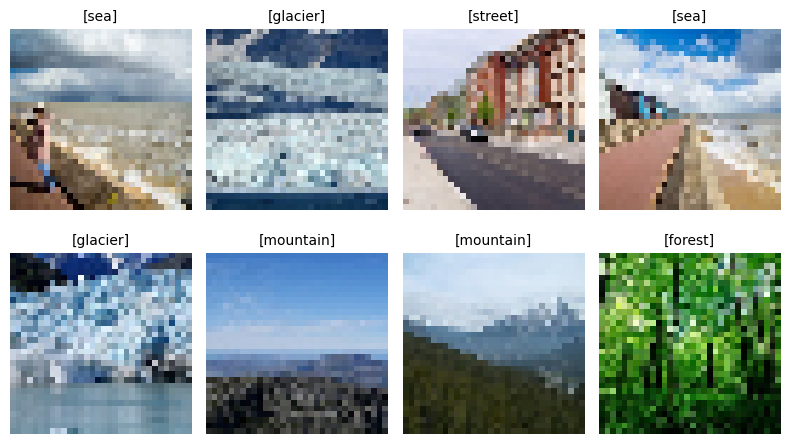

In [12]:
show_images(cnn_train_X, cnn_train_y.ravel(), nrow=2, ncol=4)

### OneHotEnconder

In [13]:
# Codifica las etiquetas con OneHotEncoder para los conjuntos de entrenamiento y Test
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

y_train = enc.fit_transform(np.array(cnn_train_y).reshape(-1, 1))
y_test  = enc.transform(np.array(cnn_test_y).reshape(-1, 1))

n_class = y_train.shape[1]
print("Clases:", enc.categories_[0])
print("n_class:", n_class)

Clases: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
n_class: 6


## 2. Red neuronal multicapa Fully Connected

Implementa una red neuronal multicapa Fully Connected para clasificar las
imágenes, las que deben contener un mínimo de cinco capas ocultas. Despliega las métricas (aplicadas al conjunto de test) que estimes conveniente para medir el rendimiento del modelo.

---

In [14]:
# preprocesamiento escalado
X_train = cnn_train_X.astype('float32')/255.0
X_test = cnn_test_X.astype('float32')/255.0
X_pred = cnn_pred_X.astype('float32')/255.0


In [15]:
mlp = Sequential()
mlp.add(Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
mlp.add(Flatten())
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(2 * n_class, activation='relu'))
mlp.add(Dense(n_class, activation='softmax', kernel_constraint=MaxNorm(3)))
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,394 (3.17 MB)

 Trainable params: 830,394 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
print("Entrenamiento Red neuronal multicapa")
epochs = 10
mlp_hist = mlp.fit(X_train, y_train, batch_size=100, epochs=epochs, validation_data=(X_test, y_test))
score = mlp.evaluate(X_test, y_test, verbose=0)
print(f'\n\n accuracy: {score[1]*100}%')

Entrenamiento Red neuronal multicapa
Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2132 - loss: 1.7430 - val_accuracy: 0.4340 - val_loss: 1.4729
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4363 - loss: 1.4179 - val_accuracy: 0.4857 - val_loss: 1.3188
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4959 - loss: 1.2928 - val_accuracy: 0.4997 - val_loss: 1.2969
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5054 - loss: 1.2513 - val_accuracy: 0.5047 - val_loss: 1.2671
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5220 - loss: 1.2257 - val_accuracy: 0.5047 - val_loss: 1.2503
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5357 - loss: 1.2007 - val_accuracy: 0.5153 - val_loss: 1.2319
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5356 - loss: 1.1900 - val_accuracy: 0.5197 - val_loss: 1.2259
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.

In [17]:
y_pred_proba = mlp.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
class_names = list(enc.categories_[0])
print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.534
              precision    recall  f1-score   support

   buildings       0.31      0.22      0.26       437
      forest       0.87      0.64      0.74       474
     glacier       0.50      0.74      0.59       553
    mountain       0.63      0.54      0.58       525
         sea       0.39      0.24      0.29       510
      street       0.51      0.78      0.62       501

    accuracy                           0.53      3000
   macro avg       0.53      0.53      0.51      3000
weighted avg       0.54      0.53      0.52      3000



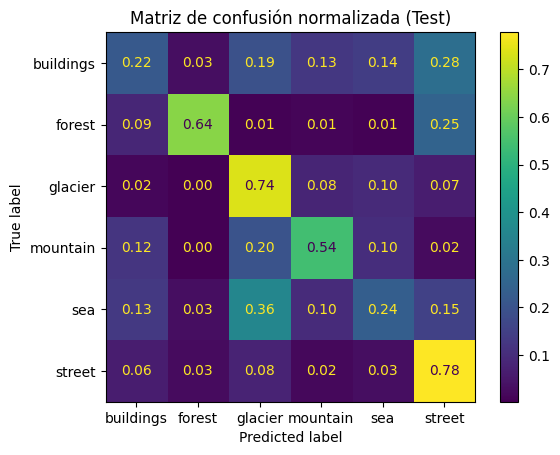

In [18]:
cm = confusion_matrix(y_true, y_pred, normalize="true")  # filas suman 1

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format=".2f")
plt.title("Matriz de confusión normalizada (Test)")
plt.show()

> **Resultado del modelo MLP**
>
> El modelo MLP no es un buen modelo para trabajar con imágenes, no se obtiene una buena diferenciación entre clases.
>
> Análisis utilizando la diagonal (recall)
> - Valores muy bajos:
>    - buildings: 0.22
>    - sea: 0.24
> - Valores mejor a la media:
>    - forest: 0.64
>    - mountain: 0.54
> - Buen desempeño:
>    - glacier: 0.74
>    - street: 0.78
> El modelo se confunde entre algunas clases:
> - sea y glacier (0.19)
> - buildings y street (0.28) y buildings y sea (0.14)


## 3. Red CNN

Desarrolla una red neuronal Convolucional usando tres o más capas convolucionales
y dos o más capas densas, de manera que la cantidad de parámetros a estimar se encuentre en el intervalo [3MM, 8MM], con 25 épocas. Muestra la curva de la pérdida para cada época y la curva de la métrica accuracy (conjunto test).

---

In [19]:
ann_cnn1 = Sequential()
# Entrada
ann_cnn1.add(Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))

# Bloque 1
ann_cnn1.add(Conv2D(64, (3, 3), use_bias=False, kernel_constraint=MaxNorm(3), padding='same'))
ann_cnn1.add(BatchNormalization())
ann_cnn1.add(Activation("relu"))
ann_cnn1.add(Conv2D(64, (3, 3), use_bias=False, kernel_constraint=MaxNorm(3), padding='same'))
ann_cnn1.add(BatchNormalization())
ann_cnn1.add(Activation("relu"))
ann_cnn1.add(MaxPooling2D((2, 2))) # 16 x 16
ann_cnn1.add(Dropout(0.20))

# Bloque 2
ann_cnn1.add(Conv2D(128, (3, 3), use_bias=False, kernel_constraint=MaxNorm(3), padding='same'))
ann_cnn1.add(BatchNormalization())
ann_cnn1.add(Activation("relu"))
ann_cnn1.add(Conv2D(128, (3, 3), use_bias=False, kernel_constraint=MaxNorm(3), padding='same'))
ann_cnn1.add(BatchNormalization())
ann_cnn1.add(Activation("relu"))
ann_cnn1.add(MaxPooling2D((2, 2))) # 8 x 8
ann_cnn1.add(Dropout(0.25))

# Bloque 3
ann_cnn1.add(Conv2D(256, (3, 3), use_bias=False, kernel_constraint=MaxNorm(3), padding='same'))
ann_cnn1.add(BatchNormalization())
ann_cnn1.add(Activation("relu"))
ann_cnn1.add(Conv2D(256, (3, 3), use_bias=False, kernel_constraint=MaxNorm(3), padding='same'))
ann_cnn1.add(BatchNormalization())
ann_cnn1.add(Activation("relu"))
ann_cnn1.add(MaxPooling2D((2, 2))) # 4 x 4
ann_cnn1.add(Dropout(0.3))

# Bloque 4 (aplanar)
ann_cnn1.add(Flatten()) # 4 x 4 x 256 = 4096
ann_cnn1.add(Dense(768, activation='relu', kernel_constraint=MaxNorm(3)))
ann_cnn1.add(Dropout(0.4))

# Bloque de clasificación
ann_cnn1.add(Dense(n_class, activation='softmax', kernel_constraint=MaxNorm(3)))

# Compilación
ann_cnn1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
ann_cnn1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 256)      │             

 Total params: 4,299,206 (16.40 MB)

 Trainable params: 4,297,414 (16.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [22]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-4,
    verbose=1
)


In [23]:
epochs = 10
ann_cnn1_hist = ann_cnn1.fit(X_train, y_train, batch_size=100, epochs=epochs, callbacks=[reduce_lr, early_stop], validation_data=(X_test, y_test))
score = ann_cnn1.evaluate(X_test, y_test, verbose=0)
print(f'\n\n accuracy: {score[1]*100}%')

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5885 - loss: 1.0104 - val_accuracy: 0.1700 - val_loss: 3.4802 - learning_rate: 2.5000e-04
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6380 - loss: 0.9251
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6381 - loss: 0.9250 - val_accuracy: 0.1700 - val_loss: 3.6478 - learning_rate: 2.5000e-04
Epoch 3/10
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6812 - loss: 0.8294
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001.
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6815 - loss: 0.8290 - val_accuracy: 0.1700 - val_loss: 3.9363 - learning_rate: 1.2500e-04
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7172 - loss: 0.7587 - val_accuracy: 0.1960 - val_loss: 2.7282 - learning_rate: 1.0000e-04
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7364 - loss: 0.7

In [24]:
y_pred_proba = ann_cnn1.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
class_names = list(enc.categories_[0])
print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.766
              precision    recall  f1-score   support

   buildings       0.77      0.74      0.75       437
      forest       0.92      0.92      0.92       474
     glacier       0.78      0.66      0.72       553
    mountain       0.80      0.64      0.71       525
         sea       0.60      0.89      0.72       510
      street       0.83      0.76      0.80       501

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.78      0.77      0.77      3000



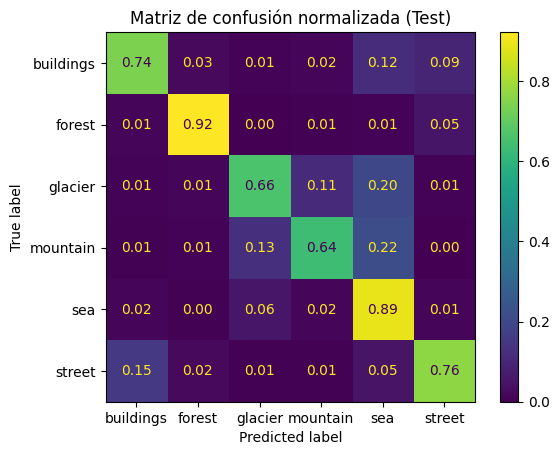

In [25]:
cm = confusion_matrix(y_true, y_pred, normalize="true")  # filas suman 1

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format=".2f")
plt.title("Matriz de confusión normalizada (Test)")
plt.show()

> **Resultado del modelo CNN **
>
> El modelo CNN mejoró los resultados del MLP.
>
> Análisis utilizando la diagonal (recall)
> - Buen desempeño:
>    - glacier: 0.66
>    - mountain: 0.64
> - Excelente desempeño
>    - street: 0.76
>    - sea: 0.89
>    - forest: 0.92
>    - buildings: 0.74
>
> El modelo se confunde entre algunas clases:
> - glacier y mauntain (0.22) y glacier y sea (0.20)
>
> Hay buena generalización, no existe diferencia importante entre los resultados de train y test (accuracy en train 0.80 vs test 0.77). Esto debido a la utilización de Eary stop y redcción de tasa de aprendizaje LR.

## 4. Red CNN Menojarado

Implementa una red neuronal Convolucional que mejore la capacidad de
generalización alcanzada en el modelo anterior. Para esto usa 16 o más capas (entre
convolucionales y densas) y mide su rendimiento.


Luego, con el modelo entrenado, aplícalo sobre el conjunto de predicción, mide su
rendimiento y compáralo con el rendimiento calculado en el modelo anterior. ¿Para
qué etiqueta el modelo se equivoca más? Muestra en forma aleatoria ocho imágenes
con la etiqueta de predicción otorgada por el modelo.

---

> Para mejorar la generación se agrega lo siguiente:
>
> 1. Relularización L2 con parámetro 1e-4
> 2. Manejo de desbalance de clases
> 3. Usar Early stop para detener el entrenamiento o cambiar parámetros durante el entrenamiento cuando se esté sobreentrenando el modelo

In [26]:
ann_cnn2 = Sequential()

def conv_bn_relu(_cnn, filters, drop, downsample):
  stride = 2 if downsample else 1
  _cnn.add(Conv2D(filters, 3, strides=stride, padding="same",
                      use_bias=False, kernel_constraint=MaxNorm(3)))
  _cnn.add(BatchNormalization())
  _cnn.add(Activation("relu"))
  _cnn.add(Conv2D(filters, 3, strides=stride, padding="same",
                      use_bias=False, kernel_constraint=MaxNorm(3)))
  _cnn.add(BatchNormalization())
  if downsample:
    _cnn.add(Conv2D(filters, 1, strides=stride, padding="same",
                            use_bias=False, kernel_constraint=MaxNorm(3))) # +1 capas
    _cnn.add(BatchNormalization())
  _cnn.add(Activation("relu"))
  _cnn.add(Dropout(drop))


# Entrada
ann_cnn2.add(Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))

# steam
ann_cnn2.add(Conv2D(64, 3, padding="same",
                    use_bias=False, kernel_constraint=MaxNorm(3))) # +1 capa
ann_cnn2.add(BatchNormalization())
ann_cnn2.add(Activation("relu"))

# Bloques
conv_bn_relu(ann_cnn2,  64, 0.20, downsample=False) # +2 capas
conv_bn_relu(ann_cnn2,  64, 0.20, downsample=False) # +2 capas
conv_bn_relu(ann_cnn2, 128, 0.25, downsample=True)  # +2 capas 16 x 16
conv_bn_relu(ann_cnn2, 128, 0.25, downsample=False) # +2 capas
conv_bn_relu(ann_cnn2, 256, 0.30, downsample=True)  # +2 capas  8 x 8
conv_bn_relu(ann_cnn2, 256, 0.30, downsample=False) # +2 capas

# Bloque aplanar
ann_cnn2.add(Flatten())
ann_cnn2.add(Dense(768, activation='relu', kernel_constraint=MaxNorm(3))) # +1 capa
ann_cnn2.add(Dropout(0.4))

# Bloque de clasificación
ann_cnn2.add(Dense(n_class, activation='softmax', kernel_constraint=MaxNorm(3))) # +1 capa

# Compilación
ann_cnn2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
ann_cnn2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 128)      │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           51

 Total params: 3,022,534 (11.53 MB)

 Trainable params: 3,018,054 (11.51 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [28]:
epochs = 10
ann_cnn2_hist = ann_cnn2.fit(X_train, y_train, batch_size=100, epochs=epochs, callbacks=[reduce_lr, early_stop], validation_data=(X_test, y_test))
score = ann_cnn2.evaluate(X_test, y_test, verbose=0)
print(f'\n\n accuracy: {score[1]*100}%')

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.3844 - loss: 1.5336 - val_accuracy: 0.1580 - val_loss: 2.4531 - learning_rate: 0.0010
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6434 - loss: 0.9235
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6435 - loss: 0.9233 - val_accuracy: 0.1700 - val_loss: 5.5425 - learning_rate: 0.0010
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7274 - loss: 0.7545
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7274 - loss: 0.7543 - val_accuracy: 0.1700 - val_loss: 8.4241 - learning_rate: 5.0000e-04
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7825 - loss: 0.6165 - val_accuracy: 0.4077 - val_loss: 1.5926 - learning_rate: 2.5000e-04
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8049 - 

In [29]:
y_pred_proba = ann_cnn2.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
class_names = list(enc.categories_[0])
print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.82
              precision    recall  f1-score   support

   buildings       0.79      0.78      0.79       437
      forest       0.91      0.97      0.94       474
     glacier       0.78      0.80      0.79       553
    mountain       0.82      0.74      0.78       525
         sea       0.77      0.85      0.81       510
      street       0.86      0.79      0.82       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



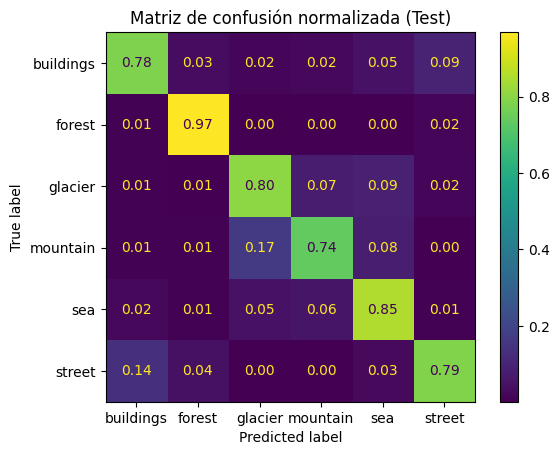

In [30]:
cm = confusion_matrix(y_true, y_pred, normalize="true")  # filas suman 1

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format=".2f")
plt.title("Matriz de confusión normalizada (Test)")
plt.show()

> **Resultado del modelo CNN mejorado**
>
> El modelo CNN mejoró los resultados del MLP.
>
> Análisis utilizando la diagonal (recall)
> - Excelente desempeño
>    - glacier: 0.80
>    - mountain: 0.74
>    - street: 0.79
>    - sea: 0.85
>    - forest: 0.97
>    - buildings: 0.78
>
> Hay buena generalización, no existe diferencia importante entre los resultados de train y test (accuracy en train 0.85 vs test 0.82).

## Conclusiones
>
> - El modelo CNN mejorado (ann_cnn2) tiene menos parámetros y aún así mejoró los resultados respecto al modelo CNN base (ann_cnn2).
>    - Modelo CNN mejorado sube de 0.77 a 0.82 el resultado de accuracy respecto al modelo CNN base.
>    - errores entre glacier - sea baja de 0.20 a 0.09.
>    - errores entre mountain - sea baja de 0.22 a 0.08.
> - Aunque también el modelo CNN Mejorado baja su recall en la clase sea (0.89 a 0.85).
> - El modelo se equivoca más con mountain (recall de 0.74, más bajo entre las demás clases). Las imágenes entre glacier y mountain se parecen.


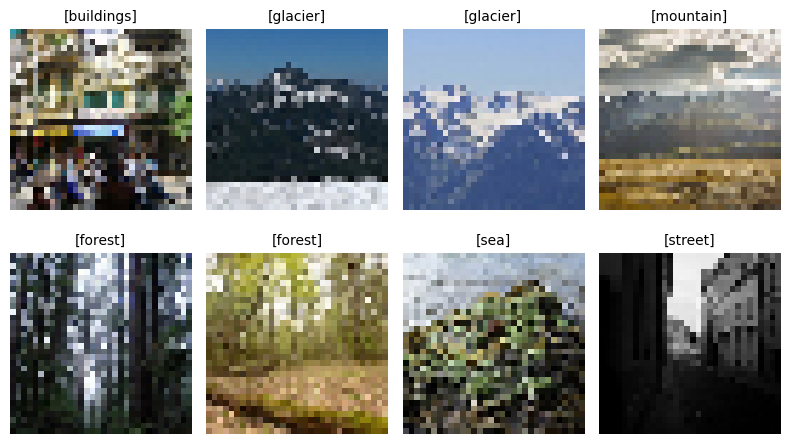

In [36]:
y_pred_proba = ann_cnn2.predict(X_pred, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y = [class_names[i] for i in y_pred]

show_images(cnn_pred_X, y, nrow=2, ncol=4)